In [27]:
import numpy as np

# 加载.npy文件
data = np.load('/home/qianghuang/CausalTransformer-main/multirun/2023-06-04/11-08-20/1/predictions_encoder.npz')

# 打印加载的数据
print(data.files)

['means', 'output', 'active_entries', 'treatments']


In [9]:
import numpy as np
data = np.load("/home/qianghuang/CausalTransformer-main/multirun/2023-08-01/18-35-33/0/test_cf_one_step.npz")
data.files

['cancer_volume',
 'chemo_application',
 'radio_application',
 'sequence_lengths',
 'patient_types',
 'prev_treatments',
 'current_treatments',
 'current_covariates',
 'outputs',
 'active_entries',
 'unscaled_outputs',
 'prev_outputs',
 'static_features']

In [28]:
predict_outcomes = data['means']
ground_outcomes = data['output']
activate_entries = data['active_entries']
treatments = data['treatments']


In [29]:
# 验证 MLflow
def calc_volume(diameter):
    return 4 / 3 * np.pi * (diameter / 2) ** 3
norm_const = calc_volume(13)
num_samples, time_dim, output_dim = data['active_entries'].shape
last_entries = data['active_entries'] - np.concatenate([data['active_entries'][:, 1:, :],
                                                                            np.zeros((num_samples, 1, output_dim))], axis=1)
mse_last = ((data['means'] - data['output']) ** 2) * last_entries

mse_last = mse_last.sum() / last_entries.sum()
rmse_normalised_last = np.sqrt(mse_last) / norm_const
rmse_normalised_last *= 100.0
rmse_normalised_last

0.7905699202266038

In [30]:
print(predict_outcomes.shape)
print(activate_entries.shape)
print(treatments.shape)
# treatments
# predict_outcomes
# ground_outcomes

(216688, 59, 1)
(216688, 59, 1)
(216688, 59, 4)


In [31]:
num_samples, time_dim, output_dim = activate_entries.shape
last_entries = activate_entries - np.concatenate([activate_entries[:, 1:, :], np.zeros((num_samples, 1, output_dim))], axis=1)
last_entries.shape
# last_predict_outcomes = predict_outcomes * last_entries
# last_ground_outcomes = ground_outcomes * last_entries

(216688, 59, 1)

In [32]:
#得到最后一个step的treatments, predict outcome, ground outcome
treatment_last_step = np.zeros((num_samples,4))
index = np.array([np.nonzero(row)[0] for row in last_entries.squeeze()]).squeeze()
last_predict_outcomes = np.zeros((num_samples,1))
last_ground_outcomes =np.zeros((num_samples,1))

In [33]:
for i in range(treatment_last_step.shape[0]): 
    treatment_last_step[i, :] = treatments[i, index[i], :]
    last_predict_outcomes[i,:] = predict_outcomes[i, index[i], :]
    last_ground_outcomes[i,:] = ground_outcomes[i, index[i], :]

In [34]:
# 得到不同treatment combination的索引
indices_1000 = np.where(np.all(treatment_last_step == [1, 0, 0, 0], axis=1))[0]
indices_0100 = np.where(np.all(treatment_last_step == [0, 1, 0, 0], axis=1))[0]
indices_0010 = np.where(np.all(treatment_last_step == [0, 0, 1, 0], axis=1))[0]
indices_0001 = np.where(np.all(treatment_last_step == [0, 0, 0, 1], axis=1))[0]
# indices_1000 = np.where(np.all(treatment_last_step == [0, 0], axis=1))[0]
# indices_0100 = np.where(np.all(treatment_last_step == [1, 0], axis=1))[0]
# indices_0010 = np.where(np.all(treatment_last_step == [0, 1], axis=1))[0]
# indices_0001 = np.where(np.all(treatment_last_step == [1, 1], axis=1))[0]
# print(indices)
print(len(indices_0001))
print(len(indices_0010))
print(len(indices_0100))
print(len(indices_1000))

54172
54172
54172
54172


In [35]:
# 得到不同treatment combination下的outcome
last_predict_outcomes_1000 = last_predict_outcomes[indices_1000, :]
last_predict_outcomes_0100 = last_predict_outcomes[indices_0100, :]
last_predict_outcomes_0010 = last_predict_outcomes[indices_0010, :]
last_predict_outcomes_0001 = last_predict_outcomes[indices_0001, :]
# ground outcomes
last_ground_outcomes_1000 = last_ground_outcomes[indices_1000, :]
last_ground_outcomes_0100 = last_ground_outcomes[indices_0100, :]
last_ground_outcomes_0010 = last_ground_outcomes[indices_0010, :]
last_ground_outcomes_0001 = last_ground_outcomes[indices_0001, :]


In [36]:
# error pehe for 0100
pehe_0100 = np.sqrt(np.mean(((last_predict_outcomes_0100-last_predict_outcomes_1000)-(last_ground_outcomes_0100-last_ground_outcomes_1000))**2))
# error pehe for 0010
pehe_0010 = np.sqrt(np.mean(((last_predict_outcomes_0010-last_predict_outcomes_1000)-(last_ground_outcomes_0010-last_ground_outcomes_1000))**2))
# error pehe for 0001
pehe_0001 = np.sqrt(np.mean(((last_predict_outcomes_0001-last_predict_outcomes_1000)-(last_ground_outcomes_0001-last_ground_outcomes_1000))**2))
pehe = (pehe_0001+pehe_0010+pehe_0100)/3/1510*100
pehe

0.6236626713822621

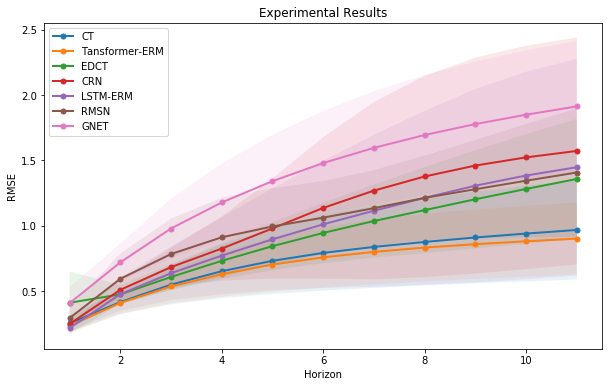

In [8]:
import matplotlib.pyplot as plt

# 实验结果数据
data = [
    ["CT", [0.2526, 0.0636], [0.4164, 0.0922], [0.5493, 0.1495], [0.652, 0.2062], [0.7315, 0.253], [0.7921, 0.2882], [0.8376, 0.3131], [0.8757, 0.332], [0.91, 0.3502], [0.9399, 0.3658], [0.9676, 0.3792]],
    ["Tansformer-ERM", [0.2345, 0.0577], [0.41, 0.0834], [0.5351, 0.1268], [0.629, 0.1699], [0.7032, 0.2077], [0.7579, 0.232], [0.7996, 0.2488], [0.8329, 0.2594], [0.8585, 0.2654], [0.881, 0.2712], [0.9011, 0.2757]],
    ["EDCT", [0.4106, 0.2388], [0.4749, 0.0722], [0.6077, 0.0997], [0.7314, 0.1386], [0.8434, 0.184], [0.9447, 0.2316], [1.0358, 0.2796], [1.1193, 0.3291], [1.2024, 0.3757], [1.2812, 0.4194], [1.3576, 0.4604]],
    ["CRN", [0.2486, 0.0324], [0.5095, 0.0759], [0.6831, 0.1479], [0.825, 0.2454], [0.9792, 0.383], [1.1362, 0.5411], [1.2685, 0.6782], [1.3765, 0.7698], [1.4602, 0.8258], [1.5227, 0.8542], [1.572, 0.868]],
    ["LSTM-ERM", [0.2175, 0.0247], [0.4759, 0.127], [0.6367, 0.2052], [0.7711, 0.2944], [0.8959, 0.3898], [1.0105, 0.4857], [1.1144, 0.5818], [1.2131, 0.6654], [1.3062, 0.7395], [1.3839, 0.7937], [1.4474, 0.8283]],
    ["RMSN", [0.293, 0.0765], [0.5938, 0.1935], [0.7833, 0.2717], [0.9115, 0.3023], [0.9942, 0.2926], [1.0616, 0.2805], [1.134, 0.291], [1.2131, 0.3232], [1.2792, 0.3768], [1.3442, 0.4344], [1.407, 0.4902]],
    ["GNET", [0.407, 0.1213], [0.7196, 0.144], [0.9786, 0.2287], [1.1778, 0.2984], [1.341, 0.3537], [1.4792, 0.3985], [1.5956, 0.4332], [1.6938, 0.4584], [1.7776, 0.4788], [1.8492, 0.4912], [1.9127, 0.4996]]
]

# 超参数范围
hyperparameters = list(range(1, 12))

# 提取均值和方差
means = []
stds = []
for row in data:
    mean_values = [item[0] for item in row[1:]]
    std_values = [item[1] for item in row[1:]]
    means.append(mean_values)
    stds.append(std_values)

# 绘制折线图
plt.figure(figsize=(10, 6))

methods = [row[0] for row in data]
for i, method in enumerate(methods):
    plt.plot(hyperparameters, means[i], '-o', linewidth=2, markersize=5, label=method)
    plt.fill_between(hyperparameters, [m - s for m, s in zip(means[i], stds[i])],
                     [m + s for m, s in zip(means[i], stds[i])], alpha=0.1)


plt.title('Experimental Results')
plt.xlabel('Horizon')
plt.ylabel('RMSE')


plt.legend()


plt.show()


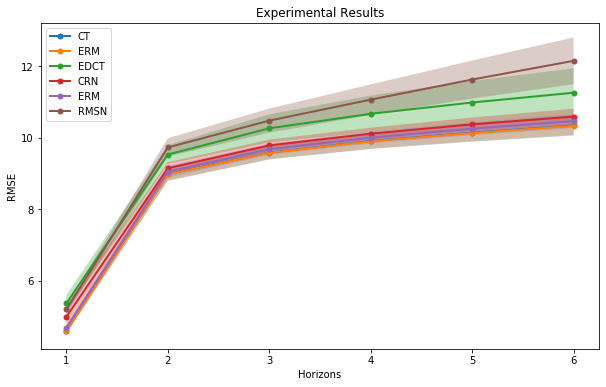

In [2]:
import matplotlib.pyplot as plt

# 实验结果数据
data = [
    ["CT", [4.5934, 0.0823], [8.9863, 0.1888], [9.5868, 0.1934], [9.9135, 0.2266], [10.1454, 0.2535], [10.3476, 0.2838]],
    ["ERM", [4.5908, 0.0855], [8.9802, 0.1814], [9.5806, 0.1789], [9.9029, 0.2047], [10.1342, 0.2273], [10.3354, 0.2551]],
    ["EDCT", [5.3614, 0.2369], [9.5311, 0.2625], [10.2655, 0.3929], [10.6728, 0.5121], [10.9889, 0.6038], [11.2625, 0.6849]],
    ["CRN", [4.9843, 0.316], [9.1488, 0.1674], [9.7878, 0.1619], [10.1161, 0.1683], [10.3767, 0.1921], [10.5927, 0.2228]],
    ["ERM", [4.6808, 0.0554], [9.0483, 0.1636], [9.6803, 0.1535], [10.004, 0.1625], [10.2566, 0.1779], [10.4691, 0.1971]],
    ["RMSN", [5.1912, 0.1169], [9.7308, 0.2557], [10.4807, 0.3374], [11.069, 0.4258], [11.632, 0.532], [12.1559, 0.6548]]
]

# 超参数范围
hyperparameters = list(range(1, 7))

# 提取均值和方差
means = []
stds = []
for row in data:
    mean_values = [item[0] for item in row[1:]]
    std_values = [item[1] for item in row[1:]]
    means.append(mean_values)
    stds.append(std_values)

# 绘制折线图
plt.figure(figsize=(10, 6))

methods = [row[0] for row in data]
for i, method in enumerate(methods):
    plt.plot(hyperparameters, means[i], '-o', linewidth=2, markersize=5, label=method)
    plt.fill_between(hyperparameters, [m - s for m, s in zip(means[i], stds[i])],
                     [m + s for m, s in zip(means[i], stds[i])], alpha=0.3)

# 设置图形标题和坐标轴标签
plt.title('Experimental Results')
plt.xlabel('Horizons')
plt.ylabel('RMSE')

# 设置图例
plt.legend()

# 展示图形
plt.show()
